In [1]:
#public data comparing microdissected glom and TI compartments
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
clean_theme <- theme_bw() + theme(axis.text = element_text(color = "black"), axis.title = element_text(color = "black"))
library(ggplot2)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
library(GEOquery)

Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)



In [3]:
eset = getGEO("GSE32591")

Found 1 file(s)

GSE32591_series_matrix.txt.gz



In [4]:
eset = eset[[1]]
#get an index of the gene names
library('org.Hs.eg.db')
eset = eset[!duplicated(featureData(eset)@data[, 'Gene Symbol']), ]
selected_genes = select(org.Hs.eg.db,
       keys = featureData(eset)@data[, 'ID'],
       columns=c("ENSEMBL","ENTREZID","SYMBOL","GENENAME"),
       keytype="ENTREZID")
selected_genes = selected_genes[!is.na(selected_genes$ENSEMBL), ]
selected_genes = selected_genes[!duplicated(selected_genes$SYMBOL), ]
rownames(selected_genes) = selected_genes$SYMBOL
#subset to sensible genes
eset = eset[featureData(eset)@data$ID %in% selected_genes$ENTREZID, ]

Loading required package: AnnotationDbi



'select()' returned 1:many mapping between keys and columns



In [5]:
type = phenoData(eset)@data$source_name_ch1

In [6]:
pc = prcomp(t(exprs(eset)))

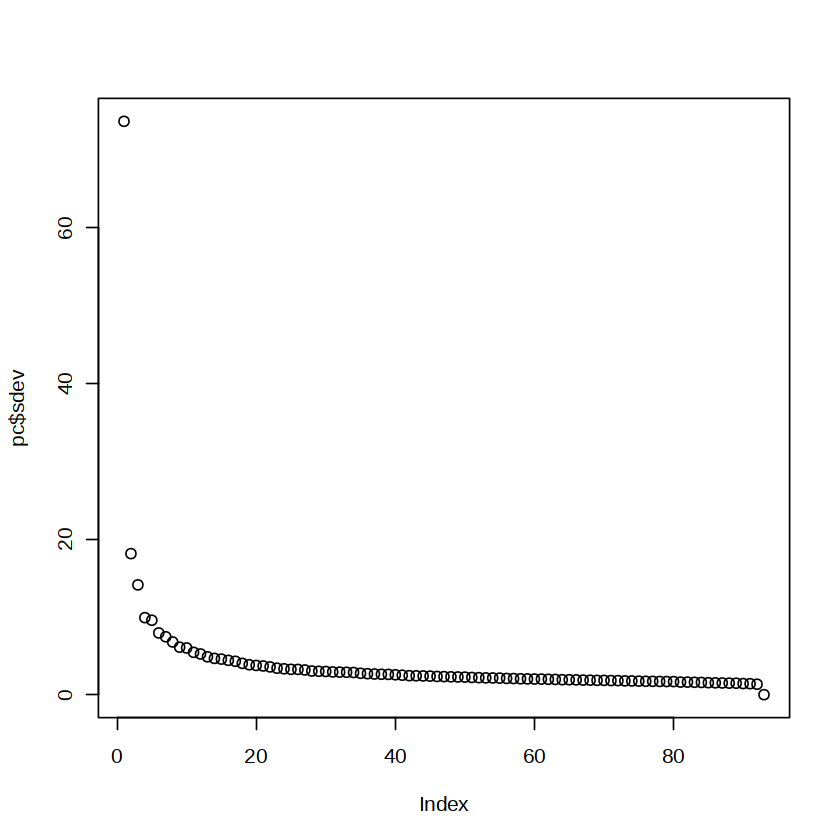

In [7]:
plot(pc$sdev)

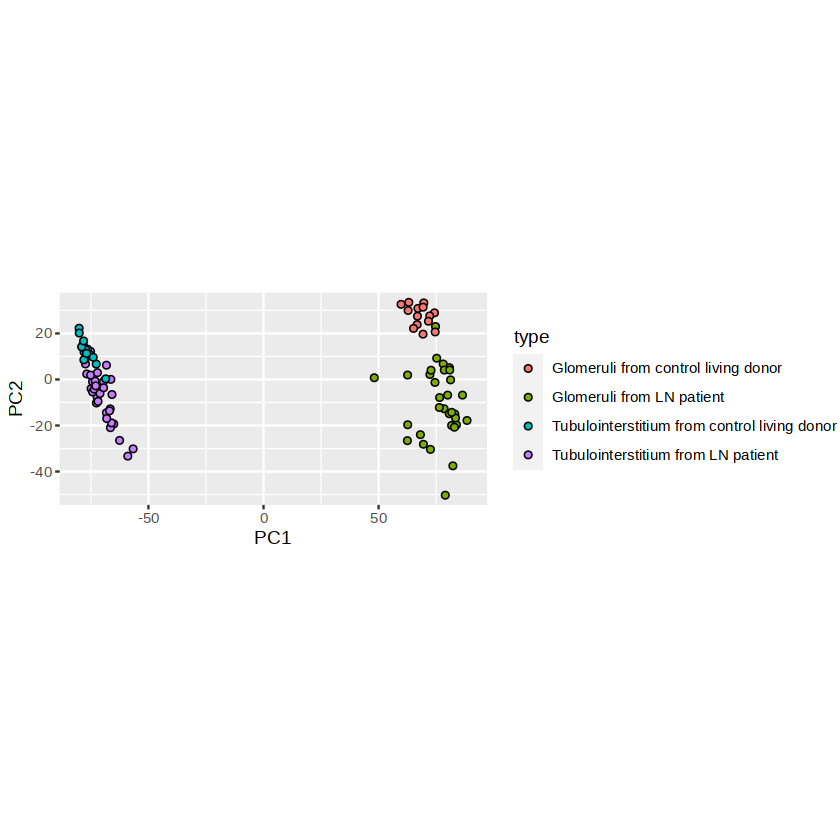

In [8]:
ggplot(data.frame(pc$x, type), aes(x = PC1, y=PC2, fill = type)) + geom_point(pch =21) + coord_fixed()

In [9]:
knn_idx <- FNN::get.knn(pc$x[, 1:10], k = 7)$nn.index
snn_el <- do.call(rbind, pblapply(1:nrow(knn_idx), function(x){
  nbrs <- knn_idx[x, ]
  nbr_list <- list()
  p = 1
  for(i in nbrs){
    nbr_1 <- nbrs 
    nbr_2 <- knn_idx[i, ]
    jdist <- length(intersect(nbr_1, nbr_2))/length(union(nbr_1, nbr_2))
    nbr_list[[p]] <- data.frame("node1" = x, "node2" = i, "jdist" = jdist)
    p = p+1
      }
  nbr_out <- do.call(rbind, nbr_list)
  return(nbr_out)
  
}))
snn_el = snn_el[snn_el[, 3] > 0, ]
gr <- graph_from_edgelist(as.matrix(snn_el[, 1:2]), directed = FALSE)
E(gr)$weight <- snn_el$jdist


In [10]:
type = phenoData(eset)@data$source_name_ch1
library(ggraph)
set.seed(100)
lay <- layout_with_fr(gr)
pl1 <- ggraph(gr, layout = lay) + geom_edge_link(edge_colour = "grey60", edge_width = 0.5) + 
  geom_node_point(pch = 21, aes(fill = factor(type)), size = 5) +
  theme_void() + coord_fixed()

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


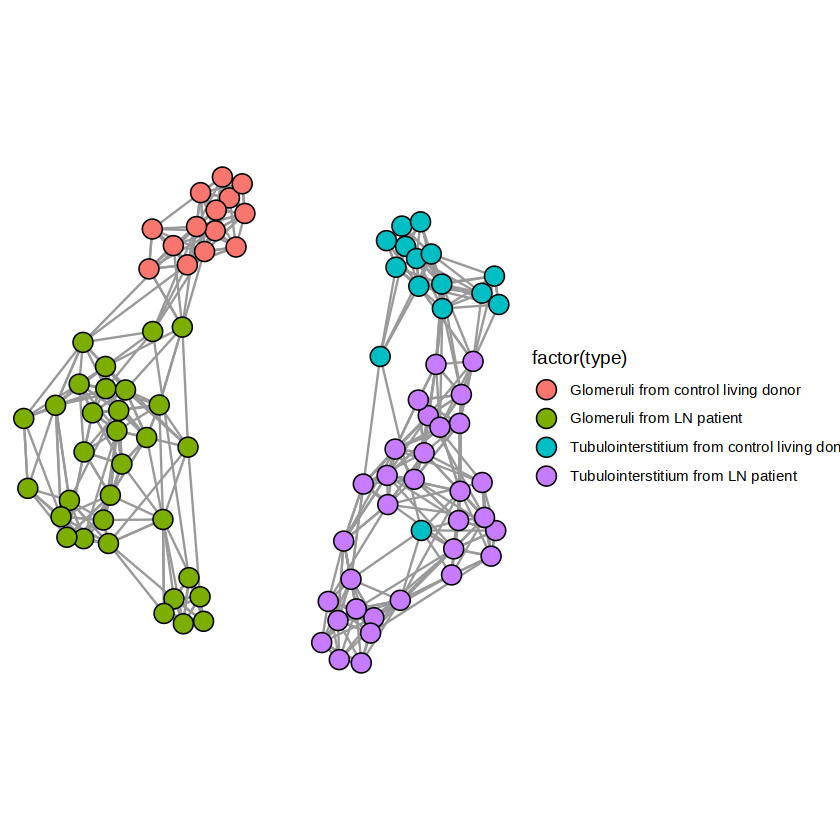

In [11]:
pl1

In [12]:
pdf("./figures/berthier_embedding.pdf")
pl1
dev.off()

png 
  2

In [13]:
genes = c("IL8", "TNF", "IL1B")
pl_list = lapply(genes, function(i){
    gene_idx = featureData(eset)@data[, 'Gene Symbol'] %in% i
    gene_exp = exprs(eset)[gene_idx, ] 
    gr = ggraph(gr, layout = lay) + geom_edge_link(edge_colour = "grey60", edge_width = 0.5) + 
  geom_node_point(pch = 21, aes(fill = gene_exp), size = 5) +
  theme_void() + coord_fixed() + scale_fill_gradientn(colors = viridis::magma(100)) +ggtitle(i)
 return(gr)
})


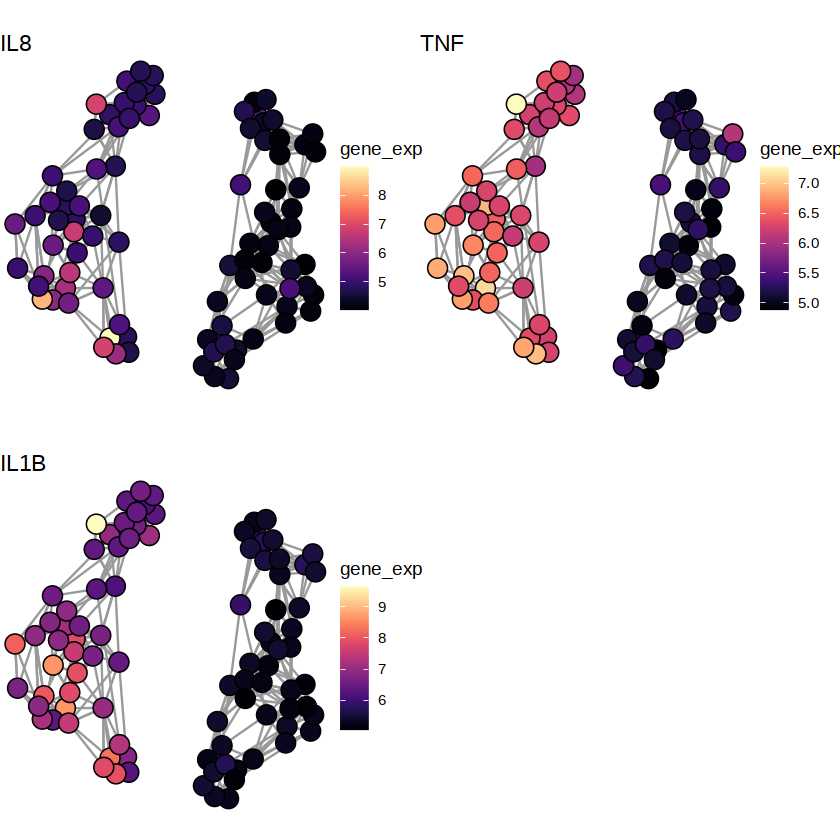

In [14]:
cowplot::plot_grid(plotlist = pl_list)

In [15]:
genes = c("IL8", "IL1B", "TNF")
df = do.call(rbind, lapply(genes, function(g){
    gene_idx =featureData(eset)@data[, 'Gene Symbol'] %in% g
gene_exp = exprs(eset)[gene_idx, ] 
df = data.frame('expression' = gene_exp, type, 'gene' = g)
return(df)  
}))
pdf("./figures/berthier_key_genes.pdf", width = 7.5, height =5)
ggplot(df, aes(x = type, y= expression, fill = type)) +  geom_boxplot(outlier.shape = NA ) + 
geom_jitter(size = 0.1) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
scale_fill_manual(values = c("darkred", "darkblue", "grey50", "grey20")) +facet_wrap(~gene, scales = "free_y")
dev.off()

png 
  2

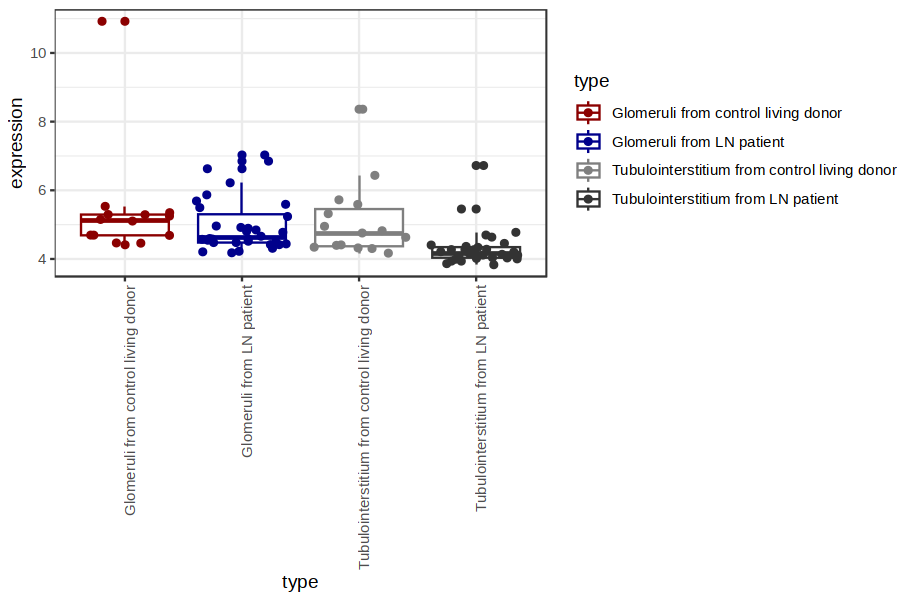

In [16]:
options(repr.plot.width = 7.5, repr.plot.height = 5)
g = 'CXCL2'
gene_idx =featureData(eset)@data[, 'Gene Symbol'] %in% g
gene_exp = exprs(eset)[gene_idx, ] 
ggplot(data.frame('expression' = gene_exp, type), aes(x = type, y = expression, color = type)) + 
geom_boxplot() + 
geom_jitter() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + scale_color_manual(values = c("darkred", "darkblue", "grey50", "grey20"))

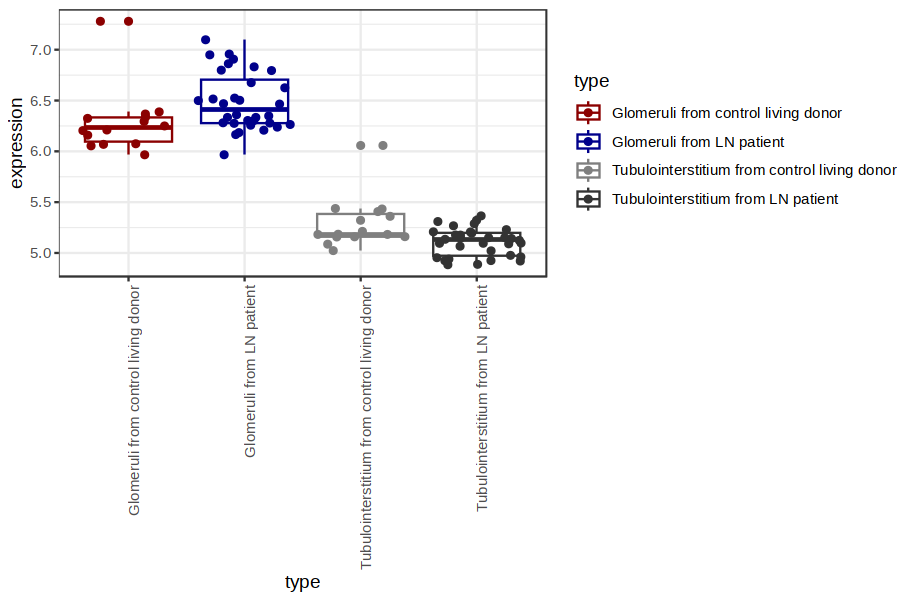

In [17]:
options(repr.plot.width = 7.5, repr.plot.height = 5)

g = 'TNF'
gene_idx =featureData(eset)@data[, 'Gene Symbol'] %in% g
gene_exp = exprs(eset)[gene_idx, ] 
ggplot(data.frame('expression' = gene_exp, type), aes(x = type, y = expression, color = type)) + 
geom_boxplot() + 
geom_jitter() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + scale_color_manual(values = c("darkred", "darkblue", "grey50", "grey20"))

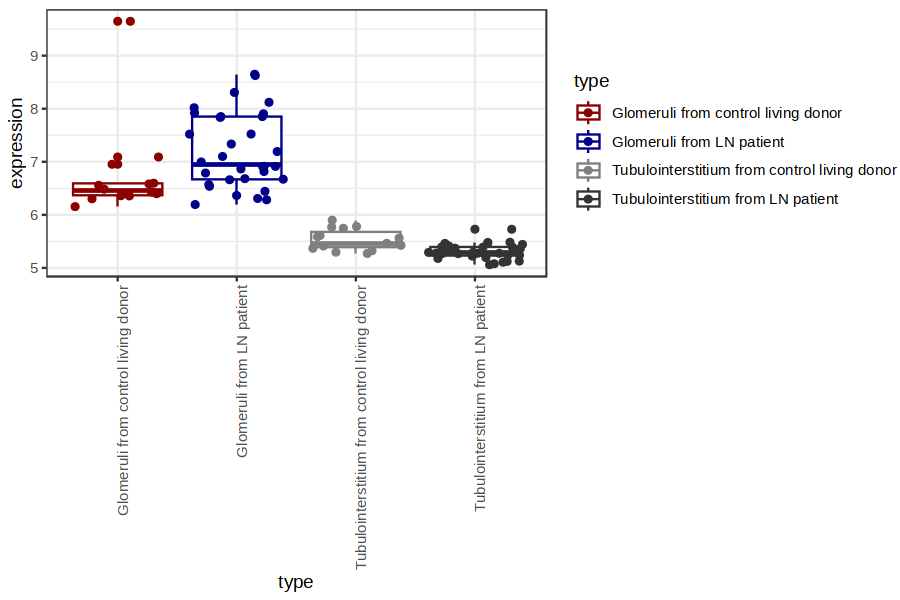

In [18]:
options(repr.plot.width = 7.5, repr.plot.height = 5)

g = 'IL1B'
gene_idx =featureData(eset)@data[, 'Gene Symbol'] %in% g
gene_exp = exprs(eset)[gene_idx, ] 
ggplot(data.frame('expression' = gene_exp, type), aes(x = type, y = expression, color = type)) + 
geom_boxplot() + 
geom_jitter() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + scale_color_manual(values = c("darkred", "darkblue", "grey50", "grey20"))

In [19]:
#do differential expression between the gloms and tubules
eset$type <- ifelse(factor(phenoData(eset)@data$'tissue:ch1') == 'Tubulointerstitium from kidney biopsy', 'ti', 'glom') # Replace the long description by short labels
eset$patient = as.numeric(factor(phenoData(eset)@data$characteristics_ch1))
# Construct design matrices by model.matrix
# model.matrix loads the columns of eset and matches to its description. 
design <- model.matrix(~ patient + type, eset) # 0 defines the way we compare the samples
#colnames(design) = c('glom', 'ti')
library(limma)
fit <- lmFit(eset, design)
cont.matrix <- makeContrasts('typeti', levels=design)
fit <- contrasts.fit(fit, cont.matrix)
# Generate the statistics
fit <- eBayes(fit, 0.05)
de_genes <- topTable(fit, coef=1, adjust="fdr", p.value=0.05, number=Inf)
de_genes = de_genes[order(de_genes$logFC, decreasing = TRUE), ]


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA


Warning message in makeContrasts("typeti", levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, cont.matrix):
“row names of contrasts don't match col names of coefficients”


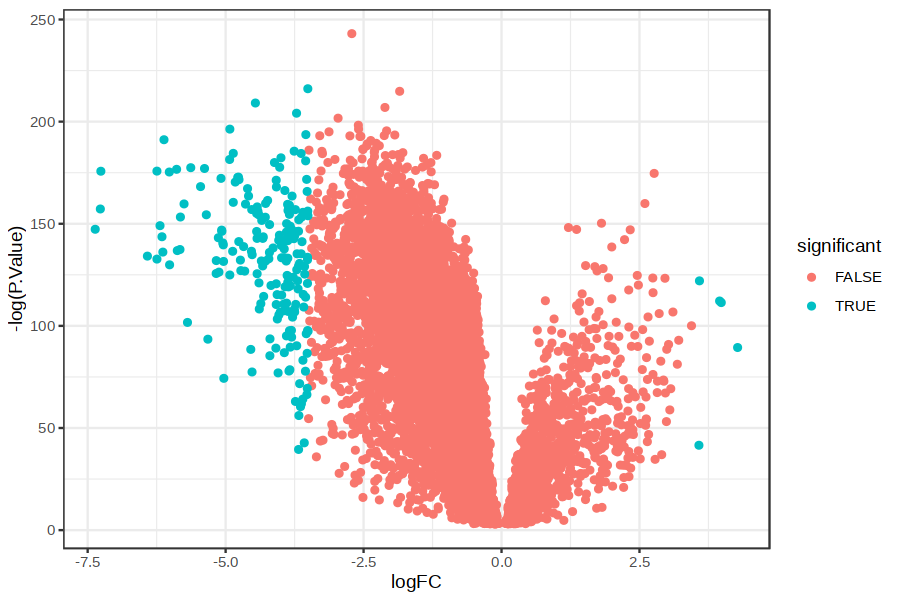

In [20]:
#plot
de_genes$significant = abs(de_genes$logFC) > 3.5 & de_genes$adj.P.Val < 0.01
ggplot(de_genes, aes(x=logFC, y = -log(P.Value), color = significant)) + geom_point() + theme_bw()

In [21]:
glom_TI_geneset = de_genes[de_genes$significant, 'Gene.Symbol']

In [22]:
#do differential expression disease and control
eset$type <- ifelse(factor(phenoData(eset)@data$'tissue:ch1') == 'Tubulointerstitium from kidney biopsy', 'ti', 'glom') # Replace the long description by short labels
eset$disease <- ifelse(phenoData(eset)@data$`disease status:ch1` == 'control', 'control', 'lupus')
# Construct design matrices by model.matrix
# model.matrix loads the columns of eset and matches to its description. 
design <- model.matrix(~type + disease, eset) # 0 defines the way we compare the samples
#colnames(design) = c('glom', 'ti')
library(limma)
fit <- lmFit(eset, design)
cont.matrix <- makeContrasts('diseaselupus', levels=design)
fit <- contrasts.fit(fit, cont.matrix)
# Generate the statistics
fit <- eBayes(fit, 0.05)
de_genes <- topTable(fit, coef=1, adjust="fdr", p.value=0.05, number=Inf)
de_genes = de_genes[order(de_genes$logFC, decreasing = TRUE), ]

Warning message in makeContrasts("diseaselupus", levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, cont.matrix):
“row names of contrasts don't match col names of coefficients”


In [23]:
lupus_geneset = de_genes[de_genes$significant & de_genes$logFC > 2, 'Gene.Symbol']

In [24]:
de_genes = de_genes[order(-log(de_genes$P.Value)*sign(de_genes$logFC), decreasing = TRUE),]
de_genes$score = -log(de_genes$P.Value)*sign(de_genes$logFC)
geneList = de_genes$score
names(geneList) = de_genes$Gene.Symbol
library(msigdbr)
hallmark_t2g =msigdbr(species= "Homo sapiens", category = 'H')
hallmark_t2g = data.frame("TERM" = hallmark_t2g$gs_name, "GENE" = hallmark_t2g$gene_symbol)
#do an enrichment analysis on this
library(clusterProfiler)
#perform GSEA on the lupus vs not lupus signature
enrichment_result <- GSEA(geneList, TERM2GENE = hallmark_t2g)
enrichment_result = enrichment_result[order(enrichment_result$NES, decreasing= TRUE), ]
enrichment_result = enrichment_result[enrichment_result$NES > 0.5, ]
enrichment_result$ID = factor(enrichment_result$ID, levels = rev(unique(enrichment_result$ID)))
pdf("./figures/berthier_enrichment_results.pdf" )
ggplot(enrichment_result, aes(y = ID, x = NES, size = -log10(pvalue), fill = NES)) + geom_point(pch=21) + 
scale_fill_gradientn(colors = viridis::viridis(10)) + theme_bw()
dev.off()



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

png 
  2

In [25]:
genes_highlight = c("IFI44", "IFI27", "IFI44L", "IFI6", "MX1", 'IFIH1', "IFIT1", "ISG15", "MX2", "IFIT3", "IFITM3", "ISG20", "IFIT2", "OAS3", "IFNAR2", "OASL")

[1] "IFI44"  "IFI27"  "IFI44L" "MX1"    "IFITM1" "IFI6"   "HERC6"  "OAS1"  
 [9] "IFIT1"  "XAF1"   "TYROBP" "ISG15"  "C1QA"   "RSAD2"  "MS4A4A" "C1QB"  
[17] "LYZ"    "IGKC"

Warning message:
“Removed 6686 rows containing missing values (`geom_text_repel()`).”


png 
  2

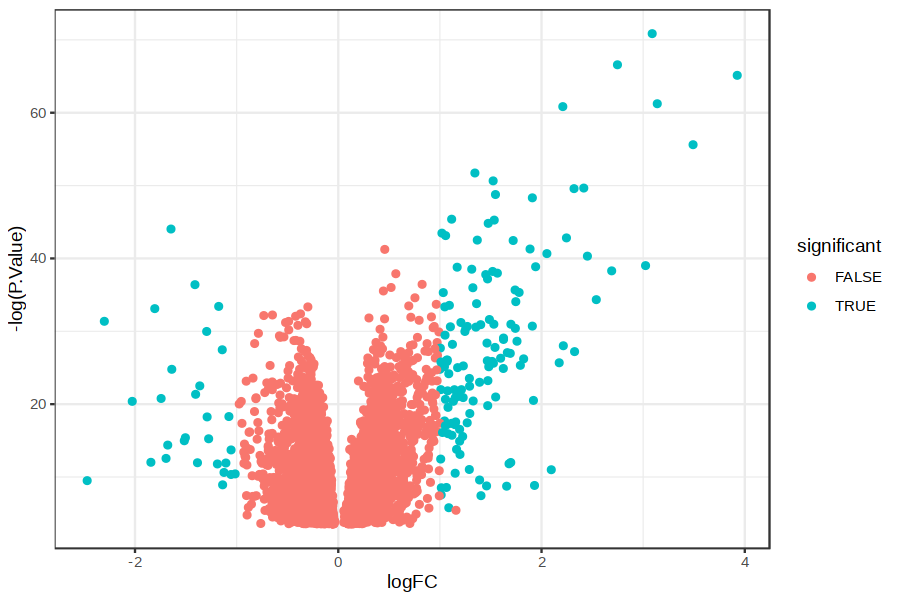

In [26]:
#plot
de_genes$significant = abs(de_genes$logFC) > 1 & de_genes$adj.P.Val < 0.01
genes_highlight = c("IFI44", "IFI27", "IFI44L", "IFI6", "MX1", 'IFIH1', "IFIT1", "ISG15", "MX2", "IFIT3", "IFITM3", "ISG20", "IFIT2", "OAS3", "IFNAR2", "OASL")
de_genes$label = de_genes$Gene.Symbol
de_genes$label[!de_genes$Gene.Symbol %in% genes_highlight] = NA
ggplot(de_genes, aes(x=logFC, y = -log(P.Value), color = significant)) + geom_point() + theme_bw()
lupus_geneset = de_genes[de_genes$significant & de_genes$logFC > 2, 'Gene.Symbol']
lupus_geneset
pdf("./figures/berthier_DE_lupus_control.pdf")
ggplot(de_genes, aes(x=logFC, y = -log(P.Value), color = significant)) + geom_point() + theme_bw() + ggrepel::geom_text_repel(aes(label = label))
dev.off()

In [27]:
#do DE between gloms lupus and healthy
#at this point we subset to just gloms
glom_eset = eset[, eset$type %in% 'glom']
glom_eset$disease <- ifelse(phenoData(glom_eset)@data$`disease status:ch1` == 'control', 'control', 'lupus')
# Construct design matrices by model.matrix
# model.matrix loads the columns of eset and matches to its description. 
design <- model.matrix(~disease, glom_eset) # 0 defines the way we compare the samples
#colnames(design) = c('glom', 'ti')
library(limma)
fit <- lmFit(glom_eset, design)
cont.matrix <- makeContrasts('diseaselupus', levels=design)
fit <- contrasts.fit(fit, cont.matrix)
# Generate the statistics
fit <- eBayes(fit, 0.05)
de_genes <- topTable(fit, coef=1, adjust="fdr", p.value=1, number=Inf)
de_genes = de_genes[order(de_genes$logFC, decreasing = TRUE), ]

Warning message in makeContrasts("diseaselupus", levels = design):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(fit, cont.matrix):
“row names of contrasts don't match col names of coefficients”


In [28]:
de_genes[de_genes$Gene.Symbol %in% c("IL8", "TNF", "IL1B"), ]

,ID,ORF,Gene.Symbol,Description,SPOT_ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3576,3576,3576,IL8,interleukin8,,0.4751430,5.410042,1.659771,0.10372932,0.18318586,-3.486736
3553,3553,3553,IL1B,"interleukin1,beta",,0.4725040,7.065378,1.977815,0.05392750,0.11190051,-2.949324
7124,7124,7124,TNF,"tumornecrosisfactor(TNFsuperfamily,member2)",,0.2025596,6.424919,2.186857,0.03384922,0.07883911,-2.553233


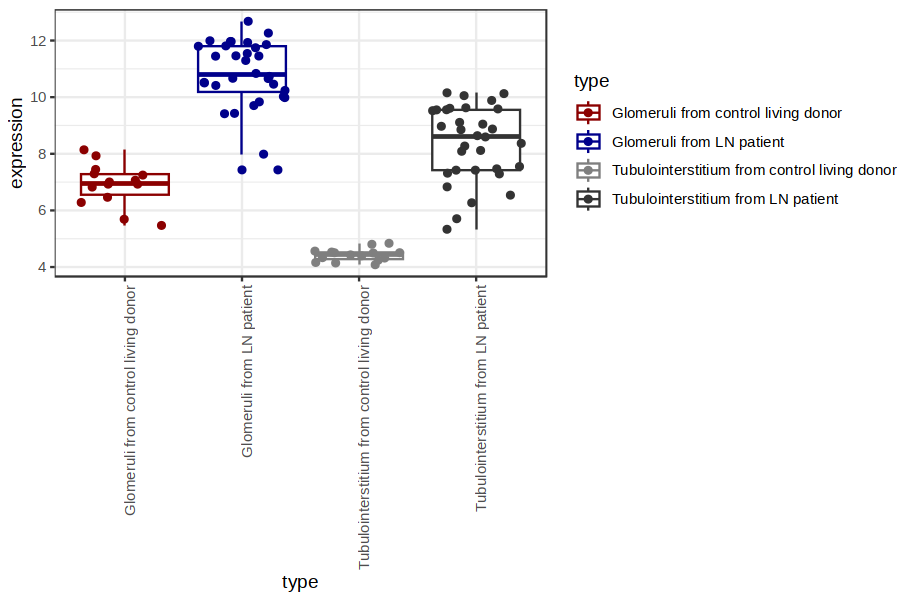

In [29]:
options(repr.plot.width = 7.5, repr.plot.height = 5)

g = 'IFI44L'
gene_idx =featureData(eset)@data[, 'Gene Symbol'] %in% g
gene_exp = exprs(eset)[gene_idx, ] 
ggplot(data.frame('expression' = gene_exp, type), aes(x = type, y = expression, color = type)) + 
geom_boxplot() + 
geom_jitter() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + scale_color_manual(values = c("darkred", "darkblue", "grey50", "grey20"))

Warning message:
“Removed 11808 rows containing missing values (`geom_text_repel()`).”


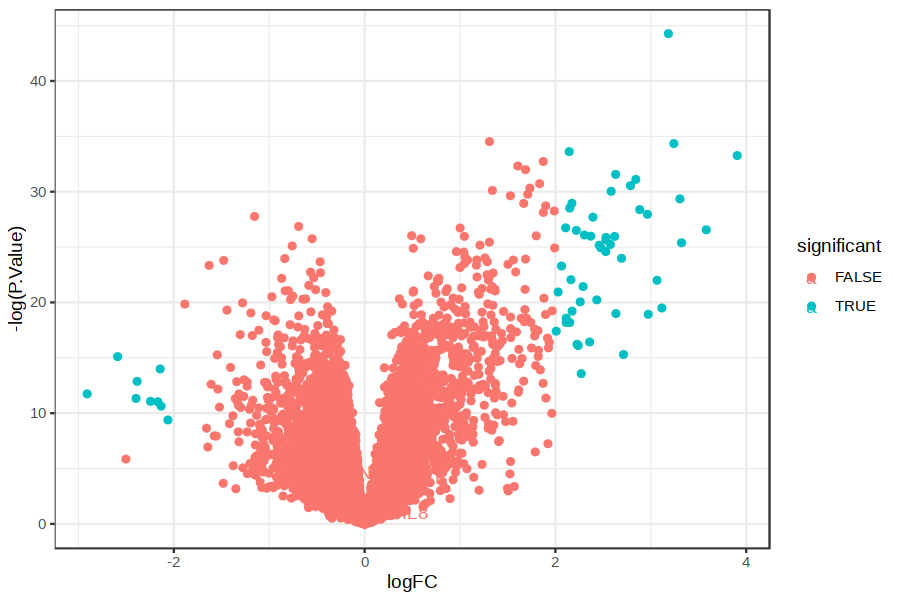

In [30]:
#plot
de_genes$label = de_genes$Gene.Symbol
de_genes$label[!de_genes$Gene.Symbol %in% c("IL8", "TNF", "IL1B")] = NA
de_genes$significant = abs(de_genes$logFC) > 2 & de_genes$adj.P.Val < 0.01
ggplot(de_genes, aes(x=logFC, y = -log(P.Value), color = significant)) + geom_point() + theme_bw()  + ggrepel::geom_text_repel(aes(label = label))